# BreaQ QML Track: Hybrid Quantum-Classical Neural Networks for RetinaMNIST

This hackathon focuses on developing hybrid quantum–classical neural networks for the RetinaMNIST dataset. *The emphasis is on designing interesting hybrid models and on finding meaningful metrics to investigate the advantage of using quantum resources.* You are encouraged to experiment with architecture design, analyze performance, and propose meaningful experiments or metrics that quantify the impact of quantum resources within the model.


In [1]:
import numpy as np
from PIL import Image
from medmnist import RetinaMNIST
import pennylane as qml
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
from typing import Tuple

## The Dataset: RetinaMNIST

RetinaMNIST is a compact medical imaging dataset composed of retinal fundus photographs labeled on a 5-point diabetic retinopathy severity scale. Although the task is inherently ordinal regression, it is often treated as a standard multi-class classification problem. Its limited size and low resolution make it well suited for rapid experimentation, benchmarking lightweight models, and evaluating hybrid quantum–classical approaches under realistic small-data constraints.

In the following, you are provided with a class to help you load and preprocess the RetinaMNIST dataset. The class handles downloading the data, applying necessary transformations, and preparing it for training and evaluation. Some of the methods already implemented:
 - `__init__`: Loads train, validation, and test splits into memory and formats images and labels.
 - `select_classes`: Filters all splits to keep only a specified set of class IDs.
 - `select_train_percentage`: Retains only a chosen fraction of the training set, with optional shuffling.
 - `normalize`: Applies either min–max scaling or standardization independently to each split.
 - `to_grayscale`: Converts all images to single-channel grayscale format.
 - `resize`: Resizes images in every split to a specified spatial resolution.

Bellow the `DataHandler` implementations there are also some usage examples.

In [2]:
class DataHandler:
    def __init__(self, download=True, as_rgb=True):
        """
        Loads train/val/test splits simultaneously.
        """
        self.datasets = {}
        self.images = {}
        self.labels = {}

        for split in ["train", "val", "test"]:
            ds = RetinaMNIST(split=split, download=download)
            imgs = ds.imgs  # (N, 28, 28)
            labels = ds.labels.squeeze()

            if imgs.ndim == 3:
                if as_rgb:
                    imgs = np.stack([imgs]*3, axis=-1)   # (N, H, W, 3)
                else:
                    imgs = imgs[..., None]               # (N, H, W, 1)

            self.images[split] = imgs.astype(np.uint8)
            self.labels[split] = labels.astype(int)

        self.active_classes = {
            split: np.unique(self.labels[split]) for split in ["train", "val", "test"]
        }

    def select_classes(self, classes):
        """
        Keep only specific class IDs across train, val, test.
        """
        for split in ["train", "val", "test"]:
            cls_set = set(classes)
            mask = np.array([lbl in cls_set for lbl in self.labels[split]])
            self.images[split] = self.images[split][mask]
            self.labels[split] = self.labels[split][mask]
            self.active_classes[split] = np.array(sorted(classes))

    def select_train_percentage(self, pct, shuffle=True, seed=None):
        """
        Keep only a percentage of the training data, preserving class proportions.
        pct: float in (0,1]
        """
        assert 0 < pct <= 1
        N = len(self.labels["train"])
        n_keep = int(N * pct)

        rng = np.random.default_rng(seed)

        classes, counts = np.unique(self.labels["train"], return_counts=True)
        # desired (float) and initial integer allocation per class
        desired = counts * pct
        per_class = np.floor(desired).astype(int)

        # adjust to match total n_keep by distributing the remaining slots
        remainder = n_keep - per_class.sum()
        if remainder > 0:
            fracs = desired - per_class
            order = np.argsort(-fracs)  # largest fractional parts first
            for i in order[:remainder]:
                per_class[i] += 1
        elif remainder < 0:
            rem = -remainder
            fracs = desired - per_class
            order = np.argsort(fracs)  # smallest fractional parts first
            for i in order:
                if per_class[i] > 0:
                    per_class[i] -= 1
                    rem -= 1
                    if rem == 0:
                        break

        # gather indices per class
        keep_idx_list = []
        for cls, k in zip(classes, per_class):
            cls_idx = np.where(self.labels["train"] == cls)[0].copy()
            if shuffle:
                rng.shuffle(cls_idx)
            if k > 0:
                keep_idx_list.append(cls_idx[:k])

        if keep_idx_list:
            keep_idx = np.concatenate(keep_idx_list)
        else:
            keep_idx = np.array([], dtype=int)

        if shuffle and keep_idx.size:
            rng.shuffle(keep_idx)

        self.images["train"] = self.images["train"][keep_idx]
        self.labels["train"] = self.labels["train"][keep_idx]
        self.active_classes["train"] = np.unique(self.labels["train"])

    def normalize(self, method="minmax"):
        """
        Normalize each split independently.
        """
        for split in ["train", "val", "test"]:
            imgs = self.images[split].astype(np.float32)

            if method == "minmax":
                min_val = imgs.min(axis=(0,1,2), keepdims=True)
                max_val = imgs.max(axis=(0,1,2), keepdims=True)
                imgs = (imgs - min_val) / (max_val - min_val + 1e-7)

            elif method == "standard":
                mean = imgs.mean(axis=(0,1,2), keepdims=True)
                std = imgs.std(axis=(0,1,2), keepdims=True) + 1e-7
                imgs = (imgs - mean) / std

            else:
                raise ValueError("Unknown normalization method.")

            self.images[split] = imgs

    def to_grayscale(self):
        """
        Convert images in all splits to grayscale.
        """
        for split in ["train", "val", "test"]:
            gray_list = []
            for img in self.images[split]:
                pil = Image.fromarray(img).convert("L")
                gray_list.append(np.array(pil))
            gray_arr = np.stack(gray_list, axis=0)
            self.images[split] = gray_arr[..., None]

    def resize(self, size):
        """
        Resize images in all splits to (width, height).
        """
        for split in ["train", "val", "test"]:
            out = []
            for img in self.images[split]:
                if img.shape[-1] == 1:
                    pil = Image.fromarray(img.squeeze(), mode="L")
                else:
                    pil = Image.fromarray(img)

                pil = pil.resize(size, Image.BILINEAR)
                arr = np.array(pil)

                if arr.ndim == 2:
                    arr = arr[..., None]

                out.append(arr)
            self.images[split] = np.stack(out, axis=0)


# ------------- Dataset wrapper -------------
def build_dataloaders_fast(dh, batch_size=128, device='cuda'):
    """
    Pre-convert all images to torch.Tensor once.
    """
    loaders = {}
    for split in ["train", "val", "test"]:
        imgs = torch.from_numpy(dh.images[split]).float()  # (N,H,W,C)
        # HWC -> CHW
        imgs = imgs.permute(0,3,1,2)
        if imgs.max() > 1.0:
            imgs /= 255.0
        labels = torch.from_numpy(dh.labels[split]).long()
        dataset = TensorDataset(imgs, labels)
        shuffle = (split == "train")
        loaders[split] = DataLoader(dataset, batch_size=batch_size,
                                    shuffle=shuffle,
                                    num_workers=4,  # increase if your CPU has cores
                                    pin_memory=True if device=='cuda' else False)
    return loaders


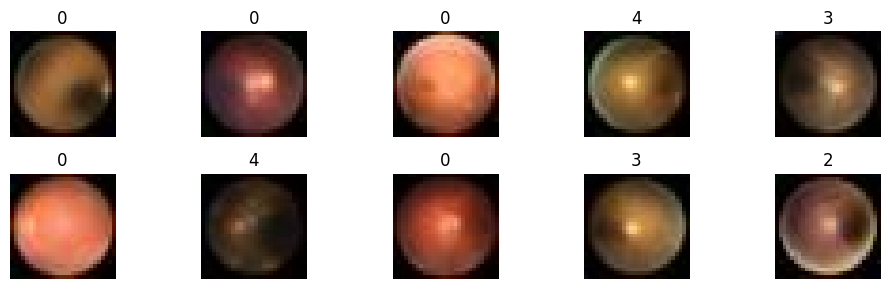

In [3]:
# Raw
import matplotlib.pyplot as plt

dh = DataHandler()

imgs = dh.images["train"][:10]
labels = dh.labels["train"][:10]

plt.figure(figsize=(10, 3))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(imgs[i])
    plt.axis("off")
    plt.title(labels[i])
plt.tight_layout()
plt.show()


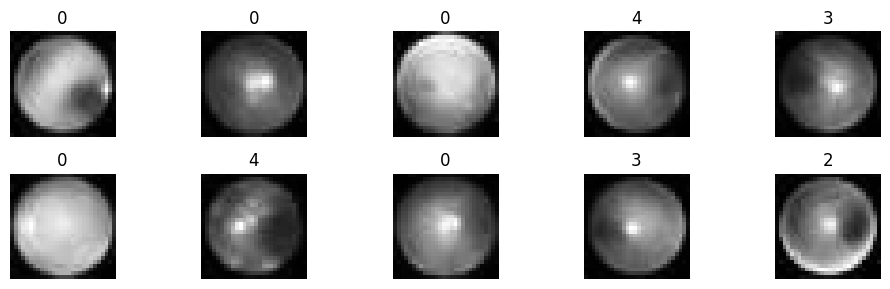

In [4]:
# Grayscale
dh = DataHandler()
dh.to_grayscale()

imgs = dh.images["train"][:10].squeeze(-1)
labels = dh.labels["train"][:10]

plt.figure(figsize=(10, 3))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(imgs[i], cmap="gray")
    plt.axis("off")
    plt.title(labels[i])
plt.tight_layout()
plt.show()

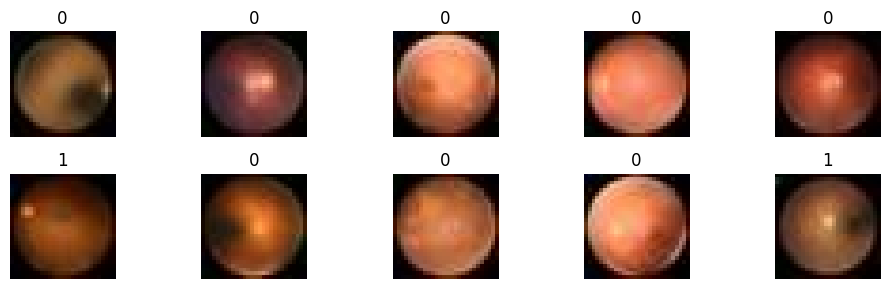

In [5]:
# Classes 0 and 1
dh = DataHandler()
dh.select_classes([0, 1])

imgs = dh.images["train"][:10]
labels = dh.labels["train"][:10]

plt.figure(figsize=(10, 3))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(imgs[i])
    plt.axis("off")
    plt.title(labels[i])
plt.tight_layout()
plt.show()

In [6]:
# keep 20% of the training set
dh = DataHandler()

print("Before:", len(dh.labels["train"]))

dh.select_train_percentage(0.2, seed=0)

print("After:", len(dh.labels["train"]))

Before: 1080
After: 216


## The model: building HQNNs with PennyLane and PyTorch

The model combines classical deep learning components from PyTorch with a trainable quantum circuit defined using PennyLane. The outer structure is a subclass of `torch.nn.Module`, which is the standard building block for neural networks in PyTorch. Layers are defined in the constructor and organized into `nn.Sequential` blocks, allowing multiple operations such as convolutions, activations, pooling, and linear layers to be stacked into a forward pipeline.

The quantum part is defined as a function decorated with `@qml.qnode`, which tells PennyLane to turn it into a differentiable quantum computation. The shape of the trainable quantum parameters is declared through `weight_shapes`, which ensures compatibility with downstream optimization. The quantum circuit is wrapped with `qml.qnn.TorchLayer`, allowing it to behave like a standard neural network layer inside PyTorch. This means it receives and outputs tensors just like a classical layer and its parameters are tracked by PyTorch’s optimizer. Both quantum and classical weights participate in the same training loop.

The `forward` method defines the flow of data: images pass first through convolutional feature extraction, then through the classifier, and finally through the quantum layer. Gradients propagate automatically across the entire pipeline. PennyLane provides differentiable quantum simulations, while PyTorch’s autograd engine ensures that parameter updates seamlessly include both the neural network weights and the quantum circuit parameters in a single backward pass.

In [ ]:
def build_model(num_classes: int, in_channels: int = 3):  # track3

    # STANDARD QUANTUM SETUP 
    n_qubits = num_classes
    dev = qml.device("default.qubit", wires=n_qubits)

    # Standard 2-layer circuit
    n_layers = 2
    weight_shapes = {"weights": (n_layers, n_qubits)}

    @qml.qnode(dev)
    def qnode(inputs, weights):
        qml.AngleEmbedding(inputs, wires=range(n_qubits))
        qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
        return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

    class ResidualHybridCNN(nn.Module):
        def __init__(self, in_ch, n_classes):
            super().__init__()


            self.features = nn.Sequential(
                nn.Conv2d(in_ch, 32, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(32),
                nn.MaxPool2d(2),

                nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(64),
                nn.MaxPool2d(2),

                nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.BatchNorm2d(128),
                nn.AdaptiveAvgPool2d(1),

                nn.Flatten()
            )

            self.drop = nn.Dropout(p=0.5)
            # PARALLEL PATHS 
            # Path A: Classical Linear Projection
            self.classical_head = nn.Linear(128, n_classes)

            # Path B: Quantum Projection
            self.quantum_head = nn.Sequential(
                nn.Linear(128, n_qubits),                 
                qml.qnn.TorchLayer(qnode, weight_shapes)  
            )

            # Learnable scaling for quantum path
            self.alpha = nn.Parameter(torch.tensor(1.0))

        def forward(self, x):
            feats = self.features(x)

            self.drop = nn.Dropout(p=0.5)
            # Two parallel paths
            c_out = self.classical_head(feats)
            q_out = self.quantum_head(feats)

            # --- RESIDUAL FUSION ---
            # return c_out + (self.alpha * q_out)   # original (with residual quantum)
            return c_out                             # ablation test (alpha = 0)

    return ResidualHybridCNN(in_channels, num_classes)


For prototyping it is useful to visualize the quantum circuits. The following cell shows how to plot a quantum circuit using PennyLane's built-in drawing capabilities. The argument `level=None` ensures that all operations are displayed without collapsing them into higher-level gates.

c:\Users\Tavi\vs_code_projects\roqteam-qml\.venv\Lib\site-packages\pennylane\workflow\construct_batch.py:418: PennyLaneDeprecationWarning: Using `level=None` is deprecated and will be removed in a future release. Please use `level='device'` to include all transforms.
  _validate_level(level)


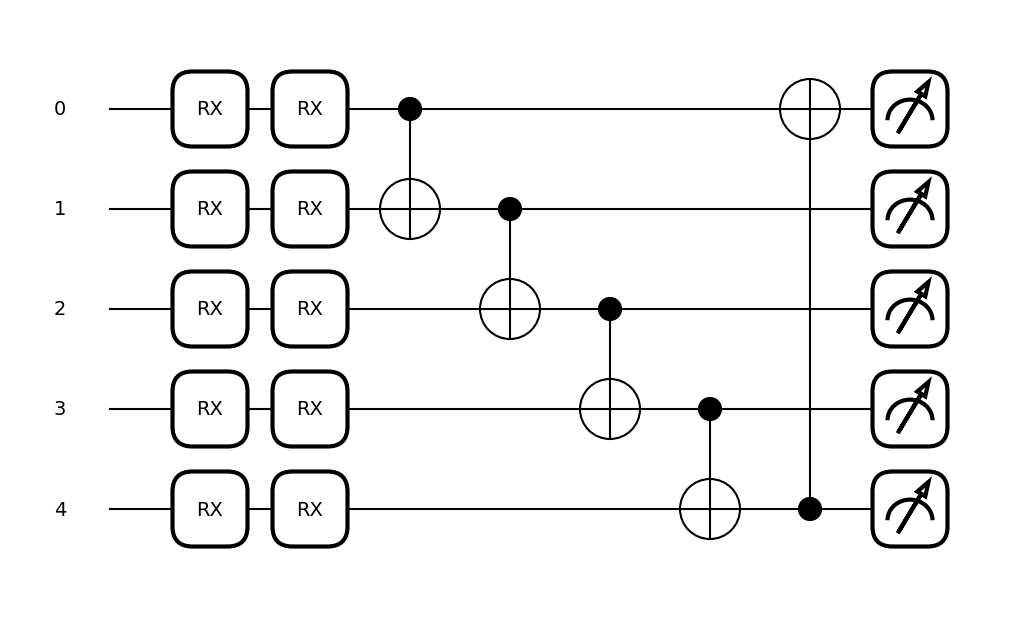

In [8]:
n_qubits = 5
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

fig, ax = qml.draw_mpl(qnode, level=None)(
    np.random.rand(n_qubits), np.random.rand(1, n_qubits)
)
plt.show()

## Training and Evaluation

The training loop follows standard PyTorch conventions. The `train_epoch` function sets the model to training mode, iterates over a data loader, performs forward and backward passes, and updates parameters using the provided optimizer. The loss is computed with a user-defined criterion, and predictions are stored for later metric calculation.

The evaluation function performs the same forward computation in evaluation mode but under `torch.no_grad()`, ensuring that no gradients are tracked and computation is more efficient. No parameter updates occur during evaluation.

In [9]:

# ------------- Training utilities -------------
def train_epoch(model, loader, optimizer, device, criterion):
    model.train()
    running_loss = 0.0
    preds_all = []
    labels_all = []

    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        preds_all.append(logits.detach().cpu().numpy())
        labels_all.append(labels.detach().cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)
    preds_all = np.concatenate(preds_all, axis=0)
    labels_all = np.concatenate(labels_all, axis=0)
    # Probabilities for AUC: softmax
    probs = torch.from_numpy(preds_all).softmax(dim=1).numpy() if preds_all.ndim==2 else preds_all
    pred_labels = probs.argmax(axis=1)
    acc = accuracy_score(labels_all, pred_labels)

    # AUC: handle binary vs multiclass
    try:
        if probs.shape[1] == 1:
            auc = roc_auc_score(labels_all, probs.ravel())
        else:
            auc = roc_auc_score(labels_all, probs, multi_class='ovr')
    except Exception:
        auc = float('nan')

    return epoch_loss, acc, auc

def evaluate(model, loader, device, criterion):
    model.eval()
    running_loss = 0.0
    preds_all = []
    labels_all = []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            logits = model(imgs)
            loss = criterion(logits, labels)

            running_loss += loss.item() * imgs.size(0)
            preds_all.append(logits.cpu().numpy())
            labels_all.append(labels.cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)
    preds_all = np.concatenate(preds_all, axis=0)
    labels_all = np.concatenate(labels_all, axis=0)
    probs = torch.from_numpy(preds_all).softmax(dim=1).numpy() if preds_all.ndim==2 else preds_all
    pred_labels = probs.argmax(axis=1)
    acc = accuracy_score(labels_all, pred_labels)
    try:
        if probs.shape[1] == 1:
            auc = roc_auc_score(labels_all, probs.ravel())
        else:
            auc = roc_auc_score(labels_all, probs, multi_class='ovr')
    except Exception:
        auc = float('nan')

    return epoch_loss, acc, auc


## Experiments

The `run_training` function automates the entire workflow of training and evaluating a model. It prepares data loaders, builds the hybrid network, and runs multiple training epochs using the provided optimizer and loss function. After each epoch, validation metrics are computed, and once finished, the model is also tested on the held-out test set. All results, including loss, accuracy, and AUC, are recorded and visualized in plots, providing a clear overview of model performance across the training process.

In [10]:

# ------------- Run full training loop -------------
def run_training(dh: DataHandler,
                 num_epochs: int = 15,
                 batch_size: int = 64,
                 lr: float = 1e-3,
                 resize: Tuple[int,int] = (64,64),
                 grayscale: bool = False,
                 train_pct: float = 1.0,
                 device: str = None):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    print("Started training on ", device, "...")

    # Optionally reduce training set
    if train_pct < 1.0:
        dh.select_train_percentage(train_pct, seed=42)

    loaders = build_dataloaders_fast(dh, batch_size=128, device=device)
    num_classes = len(np.unique(dh.labels["train"]))
    in_ch = dh.images["train"].shape[-1]

    model = build_model(num_classes=num_classes, in_channels=in_ch).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    history = {"train_loss": [], "train_acc": [], "train_auc": [],
               "val_loss": [], "val_acc": [], "val_auc": []}
    
    print("Model built...")

    for epoch in range(1, num_epochs+1):
        tr_loss, tr_acc, tr_auc = train_epoch(model, loaders["train"], optimizer, device, criterion)
        print(f"Epoch {epoch:02d} | Train loss {tr_loss:.4f} acc {tr_acc:.4f} auc {tr_auc:.4f} | ")
        val_loss, val_acc, val_auc = evaluate(model, loaders["val"], device, criterion)
        print(f"Val   loss {val_loss:.4f} acc {val_acc:.4f} auc {val_auc:.4f}")

        history["train_loss"].append(tr_loss)
        history["train_acc"].append(tr_acc)
        history["train_auc"].append(tr_auc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["val_auc"].append(val_auc)

    # final test evaluation
    test_loss, test_acc, test_auc = evaluate(model, loaders["test"], device, criterion)
    print(f"\nTest  loss {test_loss:.4f} acc {test_acc:.4f} auc {test_auc:.4f}")

    # Plot results
    epochs = np.arange(1, num_epochs+1)
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.plot(epochs, history["train_loss"], label="train")
    plt.plot(epochs, history["val_loss"], label="val")
    plt.title("Loss"); plt.xlabel("Epoch"); plt.legend()

    plt.subplot(1,3,2)
    plt.plot(epochs, history["train_acc"], label="train")
    plt.plot(epochs, history["val_acc"], label="val")
    plt.title("Accuracy"); plt.xlabel("Epoch"); plt.legend()

    plt.subplot(1,3,3)
    plt.plot(epochs, history["train_auc"], label="train")
    plt.plot(epochs, history["val_auc"], label="val")
    plt.title("AUC"); plt.xlabel("Epoch"); plt.legend()

    plt.tight_layout()
    plt.show()

    return model, history, (test_loss, test_acc, test_auc)


In [11]:
def analyze_quantum_viability(model, history, threshold=0.5):  # track3
    """
    Calculates specific metrics to check if the quantum resources
    are actually contributing to the model's success.
    """
    print("\n" + "=" * 40)
    print("QUANTUM VIABILITY REPORT")
    print("=" * 40)

    # --- METRIC 1: Alpha Magnitude---
    # Checks if the residual connection is being used.
    if hasattr(model, 'alpha'):
        alpha_val = model.alpha.item()
        print(f"1. Quantum Contribution (Alpha): {alpha_val:.4f}")
        if abs(alpha_val) < 0.1:
            print("   -> WARNING: Alpha is near zero. The quantum layer is being ignored.")
        else:
            print("   -> SUCCESS: The model is actively using the quantum output.")
    else:
        print("1. Quantum Contribution: N/A (Not a Residual Model)")

    # --- METRIC 2: Parameter Efficiency ---
    # Counts total trainable params to compare with classical baseline.
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"2. Total Trainable Parameters:   {total_params}")

    # --- METRIC 3: Convergence Speed ---
    # Finds the first epoch where Val Accuracy > threshold (e.g., 50%)
    # This helps prove "Quantum Speedup" in training.
    val_accs = history['val_acc']
    crossed_at = None

    for i, acc in enumerate(val_accs):
        if acc >= threshold:
            crossed_at = i + 1
            break

    if crossed_at:
        print(f"3. Convergence Speed:            Reached {threshold * 100}% acc at Epoch {crossed_at}")
    else:
        print(f"3. Convergence Speed:            Did not reach {threshold * 100}% acc")

    print("=" * 40 + "\n")


Running Track 3 Experiment...
Started training on  cpu ...
Model built...
Epoch 01 | Train loss 1.6061 acc 0.2398 auc 0.5665 | 
Val   loss 1.6207 acc 0.1000 auc 0.6026
Epoch 02 | Train loss 1.5143 acc 0.3759 auc 0.6510 | 
Val   loss 1.6002 acc 0.1000 auc 0.6221
Epoch 03 | Train loss 1.4873 acc 0.4102 auc 0.6625 | 
Val   loss 1.5175 acc 0.3667 auc 0.6262
Epoch 04 | Train loss 1.4678 acc 0.4352 auc 0.6805 | 
Val   loss 1.4560 acc 0.4250 auc 0.6516
Epoch 05 | Train loss 1.4553 acc 0.4472 auc 0.6922 | 
Val   loss 1.4297 acc 0.4333 auc 0.6649
Epoch 06 | Train loss 1.4414 acc 0.4565 auc 0.6988 | 
Val   loss 1.4164 acc 0.4167 auc 0.6717
Epoch 07 | Train loss 1.4323 acc 0.4694 auc 0.7067 | 
Val   loss 1.3985 acc 0.4167 auc 0.6751
Epoch 08 | Train loss 1.4263 acc 0.4620 auc 0.7091 | 
Val   loss 1.4016 acc 0.4500 auc 0.6853
Epoch 09 | Train loss 1.4161 acc 0.4787 auc 0.7174 | 
Val   loss 1.4247 acc 0.4583 auc 0.6870
Epoch 10 | Train loss 1.4050 acc 0.4843 auc 0.7271 | 
Val   loss 1.4396 acc 0.48

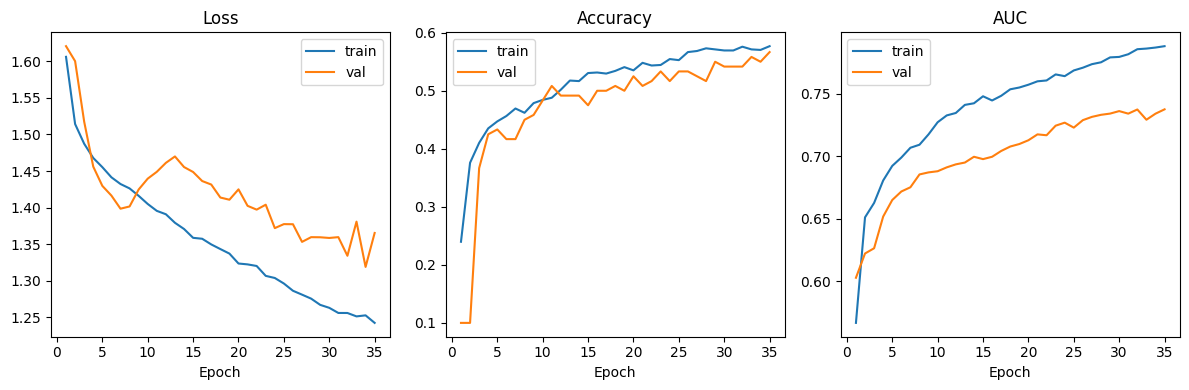


QUANTUM VIABILITY REPORT
1. Quantum Contribution (Alpha): 1.0000
   -> SUCCESS: The model is actively using the quantum output.
2. Total Trainable Parameters:   94421
3. Convergence Speed:            Reached 50.0% acc at Epoch 11

Final Test Metrics (Loss, Acc, AUC): (1.3935589694976807, 0.505, 0.6575587384340729)


In [18]:
# 1. Setup Data

dh = DataHandler(download=True, as_rgb=True)

dh.to_grayscale()

dh.normalize('minmax')

  

# 2. Run Training (Low Data Mode for Sample Efficiency Test)

print("Running Track 3 Experiment...")

model, history, test_metrics = run_training(

dh=dh,

num_epochs=35,

batch_size=128,

lr=1e-4,

resize=(64,64),

train_pct=1.0, # Use 100% data to test "Sample Efficiency"

grayscale=True, 

)

  

# 3. Analyze the new metrics

analyze_quantum_viability(model, history, threshold=0.5)

  

print(f"Final Test Metrics (Loss, Acc, AUC): {test_metrics}")

In [13]:
input = None
output = None